In [2]:
# =============================================================================
# CORE LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
import random
import pickle
import warnings
from IPython.display import display, Markdown
import ipywidgets as widgets
import time

# Ignore warnings
warnings.filterwarnings('ignore')

# =============================================================================
# MACHINE LEARNING - SCIKIT LEARN
# =============================================================================
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    accuracy_score, f1_score, precision_score, recall_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

# =============================================================================
# MACHINE LEARNING MODELS
# =============================================================================
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# =============================================================================
# DEEP LEARNING - TENSORFLOW / KERAS
# =============================================================================
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, LSTM, Dense, Dropout, 
    GlobalMaxPooling1D, Bidirectional, Concatenate, Attention
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Embedding, Conv1D, LSTM, Dense, Dropout, GlobalMaxPooling1D, Softmax
from tensorflow.keras.layers import Bidirectional, Concatenate, BatchNormalization, Lambda, Activation
from tensorflow.keras.layers import RepeatVector, Permute, Multiply, Flatten
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import *
from tensorflow.keras.layers import GaussianNoise, SpatialDropout1D 
from transformers import TFBertModel
import tensorflow as tf


# =============================================================================
# TRANSFORMERS - HUGGINGFACE
# =============================================================================
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, TFBertForSequenceClassification,
    DistilBertTokenizer, TFDistilBertForSequenceClassification,
    AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, 
    AdamWeightDecay, pipeline, TFAutoModel, AutoTokenizer,
)
from transformers import Trainer, TrainingArguments
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW

# =============================================================================
# PICKLE (OPTIONAL FOR SAVING MODELS)
# =============================================================================
import pickle


In [3]:
# Load the file
prec_df = pd.read_csv("/kaggle/input/medicine-recommendation-dataset/Training.csv")

# Show column names
print(prec_df.columns)

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)


In [4]:
# Load all the CSVs
base_path = "/kaggle/input/medicine-recommendation-dataset"

files_to_load = [
    "Symptom-severity.csv",
    "Training.csv",
    "description.csv",
    "diets.csv",
    "medications.csv",
    "precautions_df.csv",
    "symtoms_df.csv",
    "workout_df.csv"
]

# Load all files into a dictionary of DataFrames
dataframes = {}
for filename in files_to_load:
    file_path = os.path.join(base_path, filename)
    try:
        df = pd.read_csv(file_path)
        dataframes[filename] = df
    except Exception as e:
        dataframes[filename] = f"Failed to load: {e}"

dataframes.keys()  # show loaded keys (file names)



dict_keys(['Symptom-severity.csv', 'Training.csv', 'description.csv', 'diets.csv', 'medications.csv', 'precautions_df.csv', 'symtoms_df.csv', 'workout_df.csv'])

In [5]:
sample_data = {}

for name, df in dataframes.items():
    if isinstance(df, pd.DataFrame):
        sample_data[name] = df.head(3)

sample_data 

{'Symptom-severity.csv':                 Symptom  weight
 0               itching       1
 1             skin_rash       3
 2  nodal_skin_eruptions       4,
 'Training.csv':    itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
 0        1          1                     1                    0          0   
 1        0          1                     1                    0          0   
 2        1          0                     1                    0          0   
 
    chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
 0       0           0             0        0                 0  ...   
 1       0           0             0        0                 0  ...   
 2       0           0             0        0                 0  ...   
 
    blackheads  scurring  skin_peeling  silver_like_dusting  \
 0           0         0             0                    0   
 1           0         0             0                    0   
 2           0         0  

In [6]:
# ---------------------------
# Load all datasets
# ---------------------------

base_path = "/kaggle/input/medicine-recommendation-dataset"

desc_df = pd.read_csv(os.path.join(base_path, "description.csv"))
train_df = pd.read_csv(os.path.join(base_path, "Training.csv"))
med_df = pd.read_csv(os.path.join(base_path, "medications.csv"))
diet_df = pd.read_csv(os.path.join(base_path, "diets.csv"))
prec_df = pd.read_csv(os.path.join(base_path, "precautions_df.csv"))
workout_df = pd.read_csv(os.path.join(base_path, "workout_df.csv"))
symptom_df = pd.read_csv(os.path.join(base_path, "symtoms_df.csv"))
severity_df = pd.read_csv(os.path.join(base_path, "Symptom-severity.csv"))

# ---------------------------
# Normalization
# ---------------------------

def normalize(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s_-]', '', text)  # keep hyphens and underscores
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# ---------------------------
# Prepare Symptoms
# ---------------------------

all_symptoms = set()

all_symptoms.update(severity_df['Symptom'].dropna().apply(normalize))
symptom_cols = [col for col in symptom_df.columns if 'symptom' in col.lower()]
for col in symptom_cols:
    all_symptoms.update(symptom_df[col].dropna().apply(normalize))

# Define symptom columns from training data
symptom_columns = train_df.columns[1:-1]  # Exclude first and last column
for col in symptom_columns:
    all_symptoms.add(normalize(col))

all_symptoms = {s for s in all_symptoms if s and s != 'nan'}

# ---------------------------
# Build Canonical Symptom List
# ---------------------------

all_symptom_list = sorted(list(all_symptoms))

# ---------------------------
# Input Vector Conversion
# ---------------------------

def symptoms_to_input_vector(symptoms, all_symptom_list):
    vec = [0] * len(all_symptom_list)
    norm_symptoms = set(normalize(s) for s in symptoms)
    for i, s in enumerate(all_symptom_list):
        if s in norm_symptoms:
            vec[i] = 1
    return vec

# ---------------------------
# TF-IDF Vectorizer (Optional Alternative)
# ---------------------------

# You can use this for models that support dense vector input
# Uncomment if needed for text-based classification

# all_train_symptom_lists = [
#     [s for s in row[1:-1] if pd.notna(s) and s != '' and s != 'nan']
#     for _, row in train_df.iterrows()
# ]
# train_texts = [" ".join(map(normalize, symptoms)) for symptoms in all_train_symptom_lists]
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(train_texts)

# ---------------------------
# Prepare Training Data
# ---------------------------

X = []
y = []

for _, row in train_df.iterrows():
    # Extract symptom NAMES where value is 1
    symptoms = [col for col in symptom_columns if row[col] == 1]
    vec = symptoms_to_input_vector(symptoms, all_symptom_list)
    X.append(vec)
    y.append(row['prognosis'])

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# PRESERVE NUMERICAL FEATURES FOR CROSS-VALIDATION
disease_X = X  # Save numerical features with proper name
disease_y_encoded = y_encoded  # Save encoded labels

# =============================================================================
# DATA AUGMENTATION FUNCTION
# =============================================================================
def augment_data(X, y, noise_level=0.05, copies=2):
    augmented_X = []
    augmented_y = []
    
    # Convert y to list for consistent handling
    y_list = list(y)
    
    for _ in range(copies):
        for features, label in zip(X, y_list):
            # Convert to numpy array for vectorized operations
            features_arr = np.array(features)
            
            # Create random flip mask
            flip_mask = np.random.rand(len(features_arr)) < noise_level
            
            # Flip values using vectorized operations
            noisy_features = np.where(flip_mask, 1 - features_arr, features_arr)
            
            # Convert back to list and store
            augmented_X.append(noisy_features.tolist())
            augmented_y.append(label)
    
    # Return concatenated results (all as lists)
    return X + augmented_X, y_list + augmented_y

# Apply augmentation BEFORE train/test split
disease_X_aug, disease_y_encoded_aug = augment_data(disease_X, disease_y_encoded)

# =============================================================================
# MODEL TRAINING WITH REGULARIZATION
# =============================================================================

# First split ORIGINAL data (no augmentation)
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    disease_X, 
    disease_y_encoded, 
    test_size=0.2, 
    random_state=42
)

# Augmentation ONLY to training set
X_train_aug, y_train_aug = augment_data(X_train_orig, y_train_orig)

# Now train on AUGMENTED training data
model = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_aug, y_train_aug)

# Evaluate on ORIGINAL test set (no augmentation)
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# ---------------------------
# Build Knowledge Maps
# ---------------------------

def get_disease_col(df):
    cols = [c for c in df.columns if 'disease' in c.lower()]
    return cols[0] if cols else None

normalize_disease = lambda d: normalize(d)

desc_map = dict(zip(desc_df['Disease'].apply(normalize_disease), desc_df['Description']))

med_map = {}
med_col = get_disease_col(med_df)
if med_col:
    for disease, group in med_df.groupby(med_col):
        norm = normalize_disease(disease)
        meds = group['Medication'].dropna().tolist()
        med_map[norm] = ", ".join(meds) if meds else "No medication"

diet_map = {}
if 'Disease' in diet_df.columns:
    for disease, group in diet_df.groupby('Disease'):
        norm = normalize_disease(disease)
        diets = group['Diet'].dropna().tolist()
        diet_map[norm] = ", ".join(diets) if diets else "No diet"

prec_map = {}
if 'Disease' in prec_df.columns:
    prec_cols = [col for col in prec_df.columns if 'precaution' in col.lower()]
    for _, row in prec_df.iterrows():
        disease = normalize_disease(row['Disease'])
        precs = [str(row[col]) for col in prec_cols if pd.notna(row[col])]
        prec_map[disease] = ", ".join(precs) if precs else "No precautions"

work_map = {}
work_col = get_disease_col(workout_df)
if work_col and 'workout' in workout_df.columns:
    for disease, group in workout_df.groupby(work_col):
        norm = normalize_disease(disease)
        workouts = group['workout'].dropna().tolist()
        work_map[norm] = ", ".join(workouts) if workouts else "No workout"

# ---------------------------
# Severity mapping
# ---------------------------

severity_map = {}
for s, w in zip(severity_df['Symptom'], severity_df['weight']):
    canonical = normalize(s)
    if canonical not in severity_map or w > severity_map[canonical]:
        severity_map[canonical] = w

# =============================================================================
# PREDICTION FUNCTION WITH CONFIDENCE THRESHOLDING
# =============================================================================
def predict_disease(symptoms, confidence_threshold=0.7):
    input_vector = symptoms_to_input_vector(symptoms, all_symptom_list)
    probs = model.predict_proba([input_vector])[0]
    max_prob = np.max(probs)
    pred_index = np.argmax(probs)
    disease = le.inverse_transform([pred_index])[0]
    norm = normalize_disease(disease)
    
    # Get top 3 predictions
    top_indices = np.argsort(probs)[-3:][::-1]
    top_diseases = le.inverse_transform(top_indices)
    top_probs = probs[top_indices]
    
    if max_prob < confidence_threshold:
        return {
            "warning": "Low confidence prediction",
            "top_predictions": [
                {"disease": d, "confidence": float(p)} 
                for d, p in zip(top_diseases, top_probs)
            ],
            "advice": "Please consult a doctor or provide more symptoms"
        }
    
    return {
        "disease": disease.title(),
        "confidence": float(max_prob),
        "description": desc_map.get(norm, "No description available"),
        "medications": med_map.get(norm, "No medication info"),
        "diet": diet_map.get(norm, "No diet info"),
        "precautions": prec_map.get(norm, "No precautions info"),
        "workout": work_map.get(norm, "No workout info"),
        "other_possibilities": [
            {"disease": d, "confidence": float(p)} 
            for d, p in zip(top_diseases[1:], top_probs[1:])
        ]
    }

# ---------------------------
# Q&A Generation
# ---------------------------

def noisy_question(symptoms):
    kept = [s for s in symptoms if random.random() > 0.15]  # drop some symptoms
    replaced = []
    for s in kept:
        if random.random() < 0.1:
            replaced.append("slight " + s)
        else:
            replaced.append(s)
    random.shuffle(replaced)
    if len(replaced) > 1:
        return "I have " + ", ".join(replaced[:-1]) + " and " + replaced[-1]
    elif replaced:
        return "I have " + replaced[0]
    else:
        return "I feel unwell"


train_questions, train_answers = [], []
val_questions, val_answers = [], []

def build_qa_from_rows(rows, q_list, a_list):
    for _, row in rows.iterrows():
        symptoms = [col for col in symptom_columns if row[col] == 1]
        if not symptoms:
            continue
        annotated = []
        for s in symptoms:
            canonical = normalize(s)
            weight = severity_map.get(canonical, 1)
            severity = "severe" if weight > 6 else "moderate" if weight > 3 else "mild"
            annotated.append(f"{severity} {canonical}")

        # Use noisy question instead of perfect text
        question = noisy_question(annotated)

        disease = normalize(row['prognosis'])
        answer = (
            f"Based on your symptoms, you might have: {disease.title()}\n\n"
            f"**Description:** {desc_map.get(disease, 'No description')}\n\n"
            f"**Medications:** {med_map.get(disease, 'No medication')}\n\n"
            f"**Recommended Diet:** {diet_map.get(disease, 'No diet')}\n\n"
            f"**Precautions:** {prec_map.get(disease, 'No precautions')}\n\n"
            f"**Suggested Workouts:** {work_map.get(disease, 'No workout')}"
        )
        q_list.append(question)
        a_list.append(answer)

# 1. Split raw data first
train_rows, val_rows = train_test_split(train_df, test_size=0.1, random_state=42)

# 2. Prepare containers
train_questions, train_answers = [], []
val_questions, val_answers = [], []

# 3. Generate Q&A
build_qa_from_rows(train_rows, train_questions, train_answers)
build_qa_from_rows(val_rows, val_questions, val_answers)

# 4. Final DataFrames
train_qa = pd.DataFrame({'question': train_questions, 'answer': train_answers})
val_qa = pd.DataFrame({'question': val_questions, 'answer': val_answers})

print(f"Training samples: {len(train_qa)}")
print(f"Validation samples: {len(val_qa)}")


Model Accuracy: 1.00
Training samples: 4428
Validation samples: 492



Performing 10-fold cross-validation...
Verifying data types...
Type of disease_X: <class 'list'>
First element type: <class 'list'>
First element content: [0, 0, 0, 0, 0]

Cross-Validation Results (10-fold):
Average Accuracy: 1.0000 ± 0.0000
Average F1 Score: 1.0000 ± 0.0000
Average Precision: 1.0000 ± 0.0000
Average Recall: 1.0000 ± 0.0000


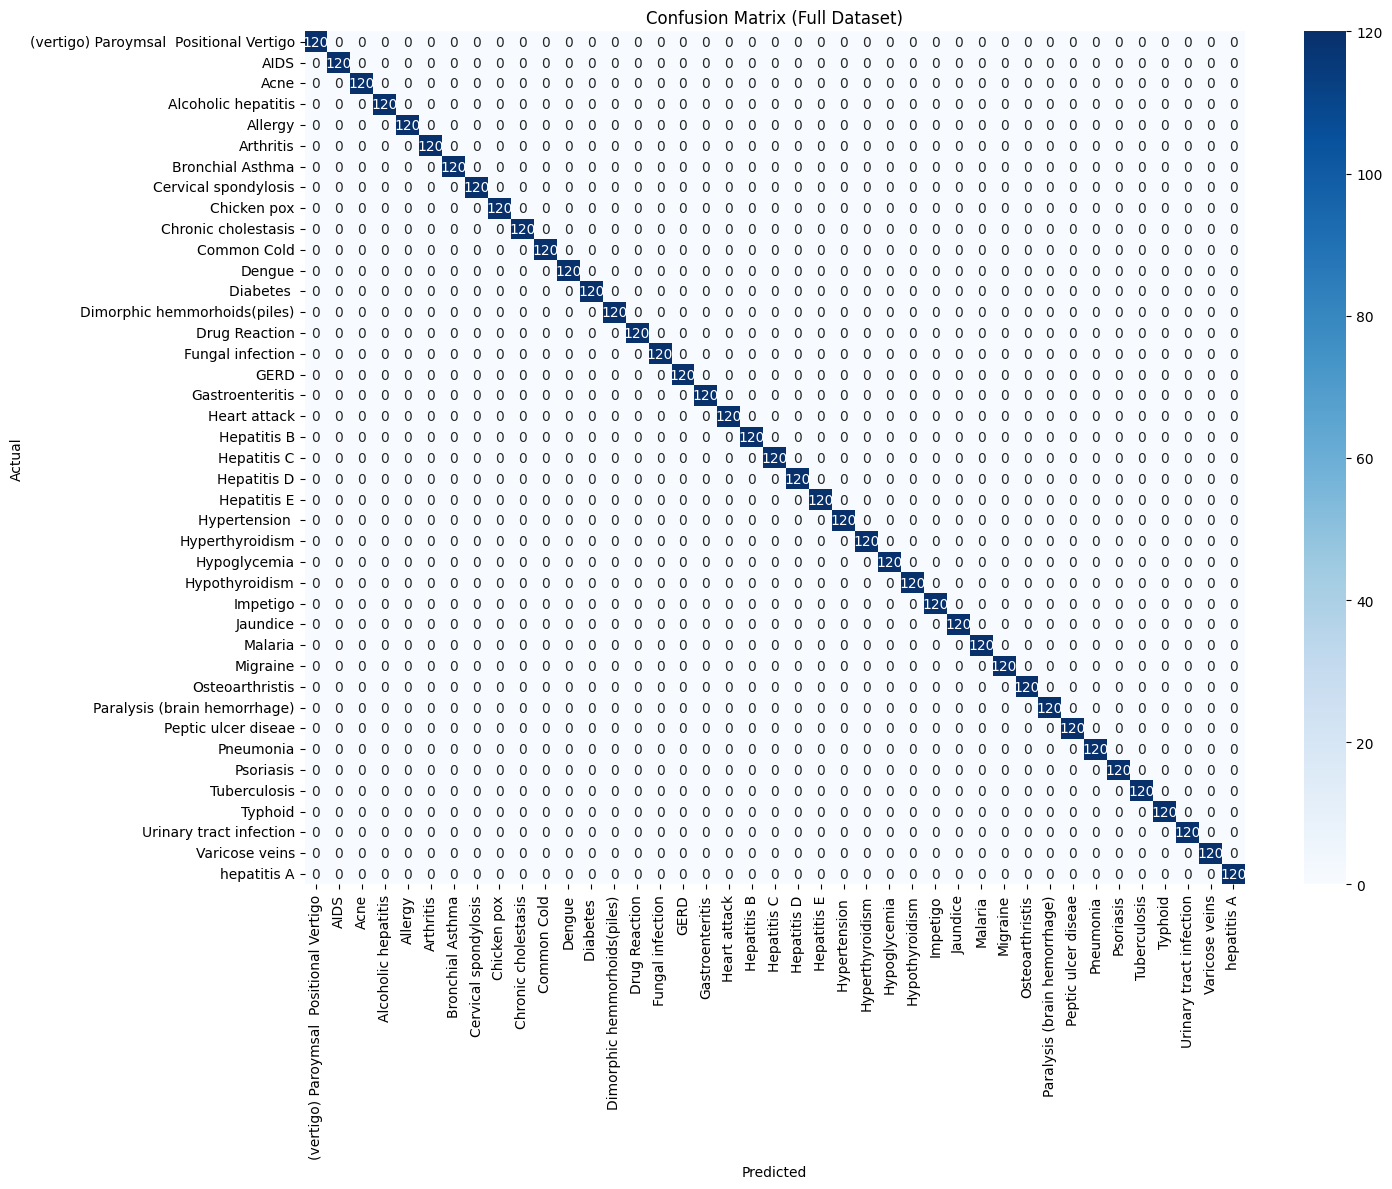


Testing prediction with sample symptoms...
Input symptoms: ['itching', 'skin_rash', 'nodal_skin_eruptions']
Prediction: {'disease': 'Fungal Infection', 'confidence': 0.96, 'description': 'Fungal infection is a common skin condition caused by fungi.', 'medications': "['Antifungal Cream', 'Fluconazole', 'Terbinafine', 'Clotrimazole', 'Ketoconazole']", 'diet': "['Antifungal Diet', 'Probiotics', 'Garlic', 'Coconut oil', 'Turmeric']", 'precautions': 'bath twice, use detol or neem in bathing water, keep infected area dry, use clean cloths', 'workout': 'Avoid sugary foods, Consume probiotics, Increase intake of garlic, Include yogurt in diet, Limit processed foods, Stay hydrated, Consume green tea, Eat foods rich in zinc, Include turmeric in diet, Eat fruits and vegetables', 'other_possibilities': [{'disease': 'Acne', 'confidence': 0.02}, {'disease': 'Allergy', 'confidence': 0.014049586776859503}]}


In [7]:
# =============================================================================
# 10-Fold Cross Validation
# =============================================================================

print("\nPerforming 10-fold cross-validation...")

# Verify we have numerical data
print("Verifying data types...")
print(f"Type of disease_X: {type(disease_X)}")
print(f"First element type: {type(disease_X[0])}")
print(f"First element content: {disease_X[0][:5]}")

# Convert to NumPy array for compatibility
X_array = np.array(disease_X)

# Initialize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

# Perform cross-validation
cv_results = cross_validate(
    rf_model,
    X_array,  
    disease_y_encoded,
    cv=10,  
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1  
)

# Print cross-validation results
print("\nCross-Validation Results (10-fold):")
print(f"Average Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Average F1 Score: {cv_results['test_f1_weighted'].mean():.4f} ± {cv_results['test_f1_weighted'].std():.4f}")
print(f"Average Precision: {cv_results['test_precision_weighted'].mean():.4f} ± {cv_results['test_precision_weighted'].std():.4f}")
print(f"Average Recall: {cv_results['test_recall_weighted'].mean():.4f} ± {cv_results['test_recall_weighted'].std():.4f}")

# =============================================================================
# Confusion Matrix Visualization
# =============================================================================

# Train final model on entire dataset for confusion matrix
model_full = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_full.fit(X_array, disease_y_encoded)
y_pred_full = model_full.predict(X_array)

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(disease_y_encoded, y_pred_full), 
            annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            cmap='Blues')
plt.title('Confusion Matrix (Full Dataset)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# =============================================================================
# Test Prediction Example
# =============================================================================
print("\nTesting prediction with sample symptoms...")
test_symptoms = ['itching', 'skin_rash', 'nodal_skin_eruptions']
print(f"Input symptoms: {test_symptoms}")
print("Prediction:", predict_disease(test_symptoms))

In [8]:
# =============================================================================
# FINE-TUNED ClinicalBERT MODEL 
# =============================================================================

# Clear session
tf.keras.backend.clear_session()

# Load ClinicalBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_bert_model = TFAutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Custom classification head
class CustomClinicalBERT(tf.keras.Model):
    def __init__(self, num_labels):
        super(CustomClinicalBERT, self).__init__()
        self.bert = clinical_bert_model
        
        # First dense block
        self.dense1 = tf.keras.layers.Dense(1024, activation=None)
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.gelu1 = tf.keras.layers.Activation(tf.nn.gelu)
        self.dropout1 = tf.keras.layers.Dropout(0.3)
        
        # Second dense block (bottleneck)
        self.dense2 = tf.keras.layers.Dense(512, activation=None)
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.gelu2 = tf.keras.layers.Activation(tf.nn.gelu)
        self.dropout2 = tf.keras.layers.Dropout(0.3)
        
        # Residual projection to match dimensions
        self.residual_proj = tf.keras.layers.Dense(1024)

        # Final classifier
        self.classifier = tf.keras.layers.Dense(num_labels, activation=None)  # logits

    def call(self, inputs, training=False):
        outputs = self.bert(inputs)
        cls_output = outputs.pooler_output  # [CLS] token
        
        # First dense block
        x = self.dense1(cls_output)
        x = self.layernorm1(x)
        x = self.gelu1(x)
        x = self.dropout1(x, training=training)
        
        # Second dense block with residual connection
        x2 = self.dense2(x)
        x2 = self.layernorm2(x2)
        x2 = self.gelu2(x2)
        x2 = self.dropout2(x2, training=training)
        
        x = x + self.residual_proj(x2)

        
        return self.classifier(x)

# =============================================================================
# FINE-TUNED ClinicalBERT MODEL (FIXED to align with Hybrid setup)
# =============================================================================

# Tokenize questions
max_length = 128
train_encodings = tokenizer(
    train_qa['question'].tolist(),
    truncation=True, padding=True, max_length=max_length, return_tensors="tf"
)
val_encodings = tokenizer(
    val_qa['question'].tolist(),
    truncation=True, padding=True, max_length=max_length, return_tensors="tf"
)

# -------------------------
# FIXED: Use 'answer' column instead of 'prognosis'
# -------------------------
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_qa['answer'])
y_val = label_encoder.transform(val_qa['answer'])

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y_train
)).shuffle(1000).batch(8)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encodings['input_ids'],
        'attention_mask': val_encodings['attention_mask']
    },
    y_val
)).batch(8)

# Initialize model with correct number of labels (medicine, diet, precaution, etc.)
num_labels = len(label_encoder.classes_)
clinical_model = CustomClinicalBERT(num_labels=num_labels)

# Build model with dummy input
dummy_input = {'input_ids': tf.zeros((1,128), dtype=tf.int32),
               'attention_mask': tf.zeros((1,128), dtype=tf.int32)}
_ = clinical_model(dummy_input)

# Optimizer, loss, metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# History lists
train_loss_history = []
train_acc_history = []
val_acc_history = []

# Training loop
epochs = 50
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    epoch_train_loss = []

    # Training
    for batch in train_dataset:
        inputs, labels = batch
        with tf.GradientTape() as tape:
            logits = clinical_model(inputs, training=True)
            loss = loss_fn(labels, logits)
        gradients = tape.gradient(loss, clinical_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, clinical_model.trainable_variables))
        train_acc_metric.update_state(labels, logits)
        epoch_train_loss.append(loss.numpy())

    avg_train_loss = np.mean(epoch_train_loss)
    train_loss_history.append(avg_train_loss)

    train_acc = train_acc_metric.result().numpy()
    train_acc_history.append(train_acc)
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    train_acc_metric.reset_state()

    # Validation
    for val_batch in val_dataset:
        inputs, labels = val_batch
        val_logits = clinical_model(inputs, training=False)
        val_acc_metric.update_state(labels, val_logits)

    val_acc = val_acc_metric.result().numpy()
    val_acc_history.append(val_acc)
    print(f"Validation Accuracy: {val_acc:.4f}")

    val_acc_metric.reset_state()

# Final evaluation
y_true, y_pred = [], []
for val_batch in val_dataset:
    inputs, labels = val_batch
    logits = clinical_model(inputs, training=False)
    preds = tf.argmax(logits, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

bert_accuracy = accuracy_score(y_true, y_pred)
print(f"\nClinicalBERT Model Validation Accuracy: {bert_accuracy:.4f}")

# Save the fine-tuned model
clinical_model.save("fine_tuned_clinical_bert.h5")  
tokenizer.save_pretrained("fine_tuned_clinical_bert_tokenizer")


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tf_model.h5:   0%|          | 0.00/527M [00:00<?, ?B/s]

I0000 00:00:1756314453.332060      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
Some layers from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT.
If your task is similar to the task the model of the che


Epoch 1/1
Training Loss: 3.8218, Training Accuracy: 0.0472
Validation Accuracy: 0.1606

ClinicalBERT Model Validation Accuracy: 0.1606


('fine_tuned_clinical_bert_tokenizer/tokenizer_config.json',
 'fine_tuned_clinical_bert_tokenizer/special_tokens_map.json',
 'fine_tuned_clinical_bert_tokenizer/vocab.txt',
 'fine_tuned_clinical_bert_tokenizer/added_tokens.json',
 'fine_tuned_clinical_bert_tokenizer/tokenizer.json')

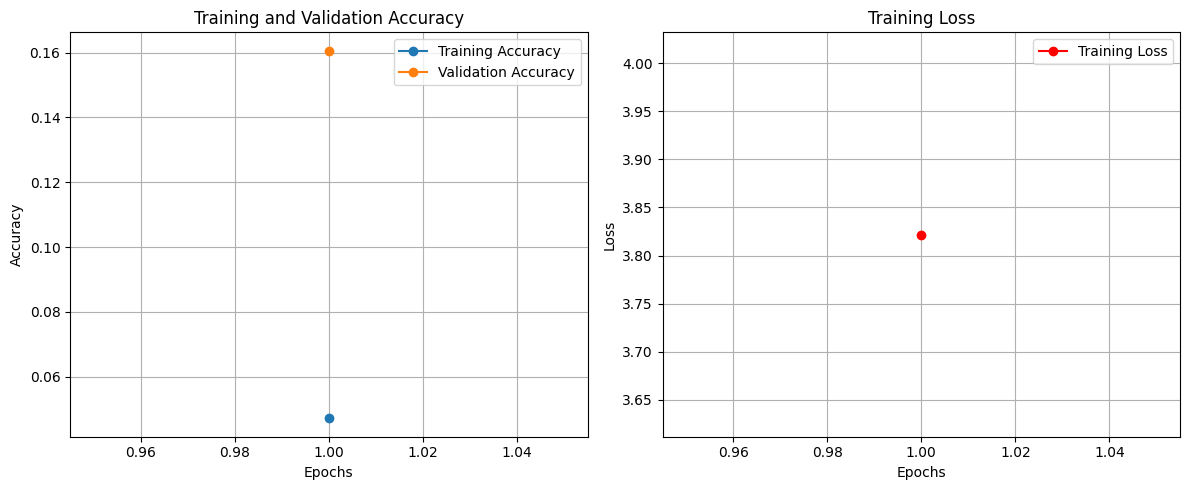

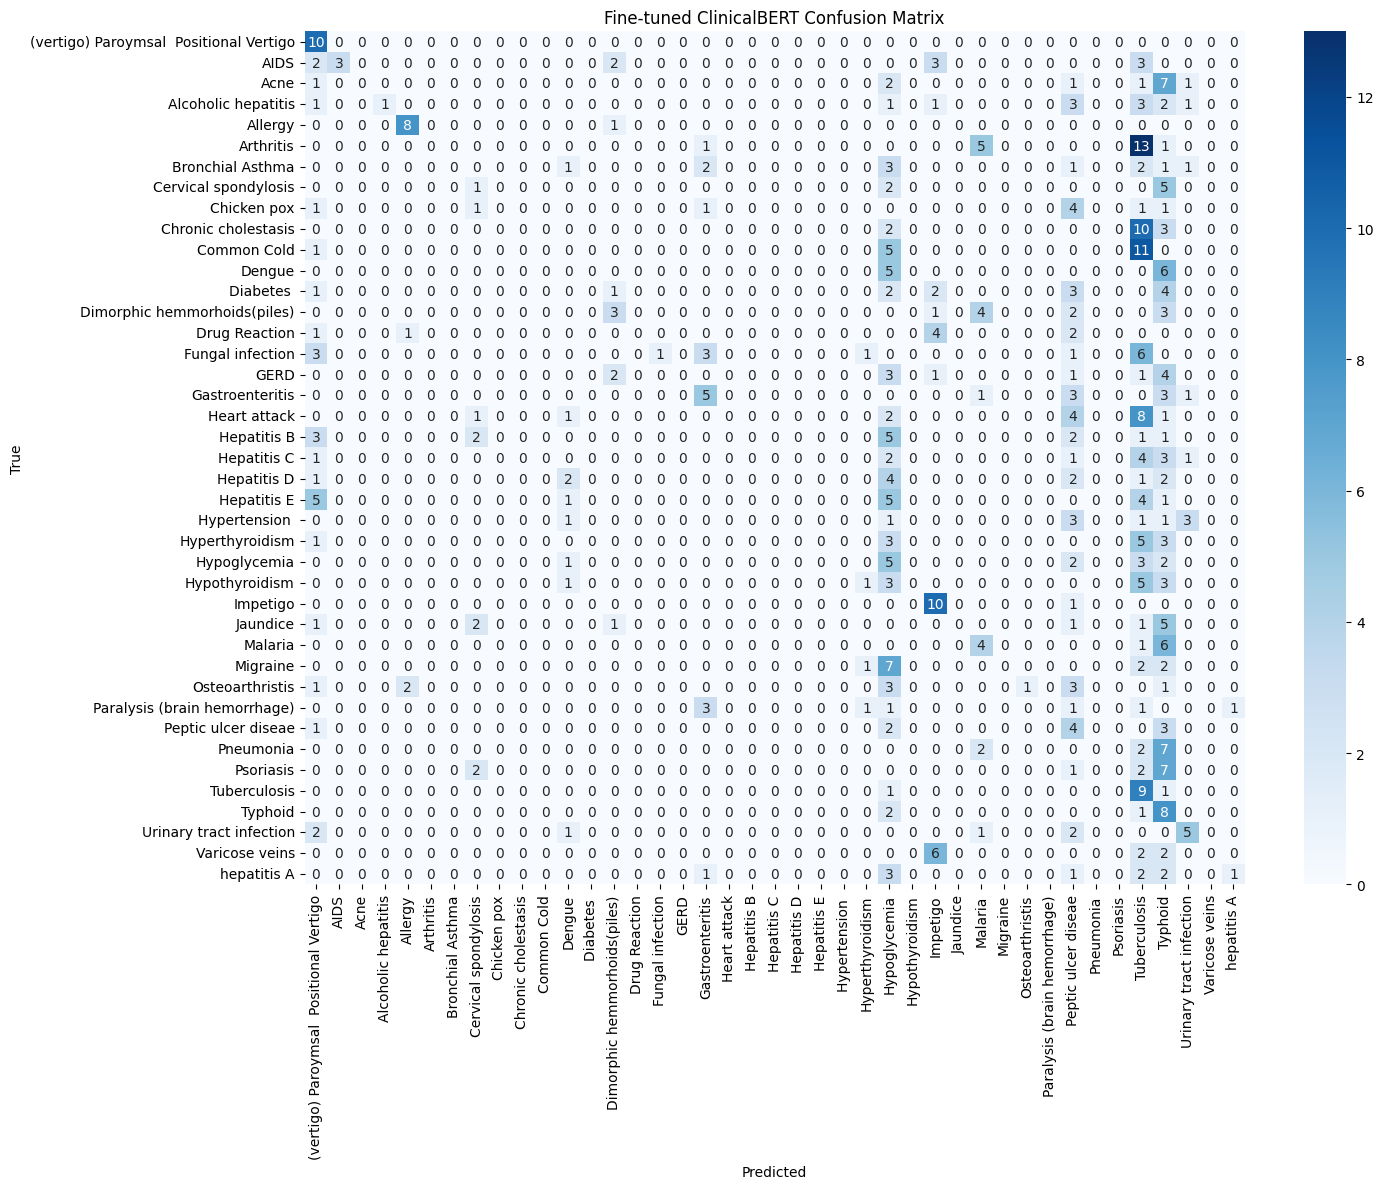

Classification Report:

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo     0.2703    1.0000    0.4255        10
                                   AIDS     1.0000    0.2308    0.3750        13
                                   Acne     0.0000    0.0000    0.0000        13
                    Alcoholic hepatitis     1.0000    0.0769    0.1429        13
                                Allergy     0.7273    0.8889    0.8000         9
                              Arthritis     0.0000    0.0000    0.0000        20
                       Bronchial Asthma     0.0000    0.0000    0.0000        11
                   Cervical spondylosis     0.1111    0.1250    0.1176         8
                            Chicken pox     0.0000    0.0000    0.0000         9
                    Chronic cholestasis     0.0000    0.0000    0.0000        15
                            Common Cold     0.0000    0.0000    0.0000        17
   

In [9]:
# -------------------------
# Plot training history
# -------------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_acc_history, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_loss_history, label='Training Loss', marker='o', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------
# Final evaluation
# -------------------------
y_true, y_pred = [], []
for val_batch in val_dataset:
    inputs, labels = val_batch
    logits = clinical_model(inputs, training=False)   # fixed
    preds = tf.argmax(logits, axis=1)
    y_true.extend(labels.numpy().flatten())
    y_pred.extend(preds.numpy().flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -------------------------
# Confusion matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)   # fixed
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Fine-tuned ClinicalBERT Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# -------------------------
# Precision, Recall, F1
# -------------------------
report = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)  # fixed
print("Classification Report:\n")
print(report)

# -------------------------
# Accuracy
# -------------------------
final_accuracy = accuracy_score(y_true, y_pred)
print(f"\nCustom ClinicalBERT Model Accuracy: {final_accuracy:.4f}")


In [10]:
# ===== Pack & Zip your existing H5 + HF tokenizer =====
import os, json, shutil, subprocess

BASE = "/kaggle/working"
SRC_H5 = "fine_tuned_clinical_bert.h5"
SRC_TOK = "fine_tuned_clinical_bert_tokenizer"   # created by tokenizer.save_pretrained(...)

# 1) Make export folder
EXPORT_DIR = os.path.join(BASE, "bertclinical_export")
os.makedirs(EXPORT_DIR, exist_ok=True)

# 2) Copy model.h5
if not os.path.isfile(SRC_H5):
    raise FileNotFoundError(f"Could not find {SRC_H5} in the current directory.")
shutil.copy2(SRC_H5, os.path.join(EXPORT_DIR, "model.h5"))

# 3) Copy tokenizer folder as ./tokenizer/
TOK_DST = os.path.join(EXPORT_DIR, "tokenizer")
if not os.path.isdir(SRC_TOK):
    raise FileNotFoundError(f"Could not find tokenizer folder: {SRC_TOK}")
shutil.copytree(SRC_TOK, TOK_DST, dirs_exist_ok=True)

# 4) Save label classes and config
#    le = your LabelEncoder used for training (as in your code)
with open(os.path.join(EXPORT_DIR, "label_classes.json"), "w") as f:
    json.dump(list(getattr(le, "classes_", [])), f)

with open(os.path.join(EXPORT_DIR, "config.json"), "w") as f:
    json.dump({
        "format": "h5",
        "max_length": int(max_length),        # 128 in your code
        "model_name": "emilyalsentzer/Bio_ClinicalBERT"
    }, f, indent=2)

print("✅ Collected artifacts in:", EXPORT_DIR)

# 5) Zip it for download
ZIP_PATH = os.path.join(BASE, "bertclinical_export.zip")
shutil.make_archive(ZIP_PATH[:-4], "zip", EXPORT_DIR)
print("📦 Zipped at:", ZIP_PATH)

# (Optional) show a quick tree
subprocess.run(["bash","-lc", f"ls -R {EXPORT_DIR} && echo '---' && unzip -l {ZIP_PATH} | sed -n '1,120p'"], check=False)

✅ Collected artifacts in: /kaggle/working/bertclinical_export
📦 Zipped at: /kaggle/working/bertclinical_export.zip
/kaggle/working/bertclinical_export:
config.json
label_classes.json
model.h5
tokenizer

/kaggle/working/bertclinical_export/tokenizer:
special_tokens_map.json
tokenizer_config.json
tokenizer.json
vocab.txt
---
Archive:  /kaggle/working/bertclinical_export.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2025-08-27 17:13   tokenizer/
  7568040  2025-08-27 17:13   model.h5
      702  2025-08-27 17:14   label_classes.json
       92  2025-08-27 17:14   config.json
   669175  2025-08-27 17:13   tokenizer/tokenizer.json
   213450  2025-08-27 17:13   tokenizer/vocab.txt
     1300  2025-08-27 17:13   tokenizer/tokenizer_config.json
      125  2025-08-27 17:13   tokenizer/special_tokens_map.json
---------                     -------
  8452884                     8 files


CompletedProcess(args=['bash', '-lc', "ls -R /kaggle/working/bertclinical_export && echo '---' && unzip -l /kaggle/working/bertclinical_export.zip | sed -n '1,120p'"], returncode=0)

In [16]:
from IPython.display import FileLink, FileLinks

# Auto-download trigger (works in Jupyter/Colab/Kaggle)
from google.colab import files
# Clickable link to download the zip
display(FileLink("/kaggle/working/bertclinical_export.zip"))


/kaggle/working/bertclinical_export.zip